In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import os
import pathlib
import random
import datetime
import matplotlib.cbook as cbook
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.losses import mae, mse
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from sklearn.pipeline import Pipeline

data_dir = pathlib.Path("101_food_classes_10_percent/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['beet_salad' 'escargots' 'mussels']


Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (384, 512, 3)
Image shape: (384, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 512, 3)
Image shape: (512, 384, 3)
Image shape: (512, 512, 3)


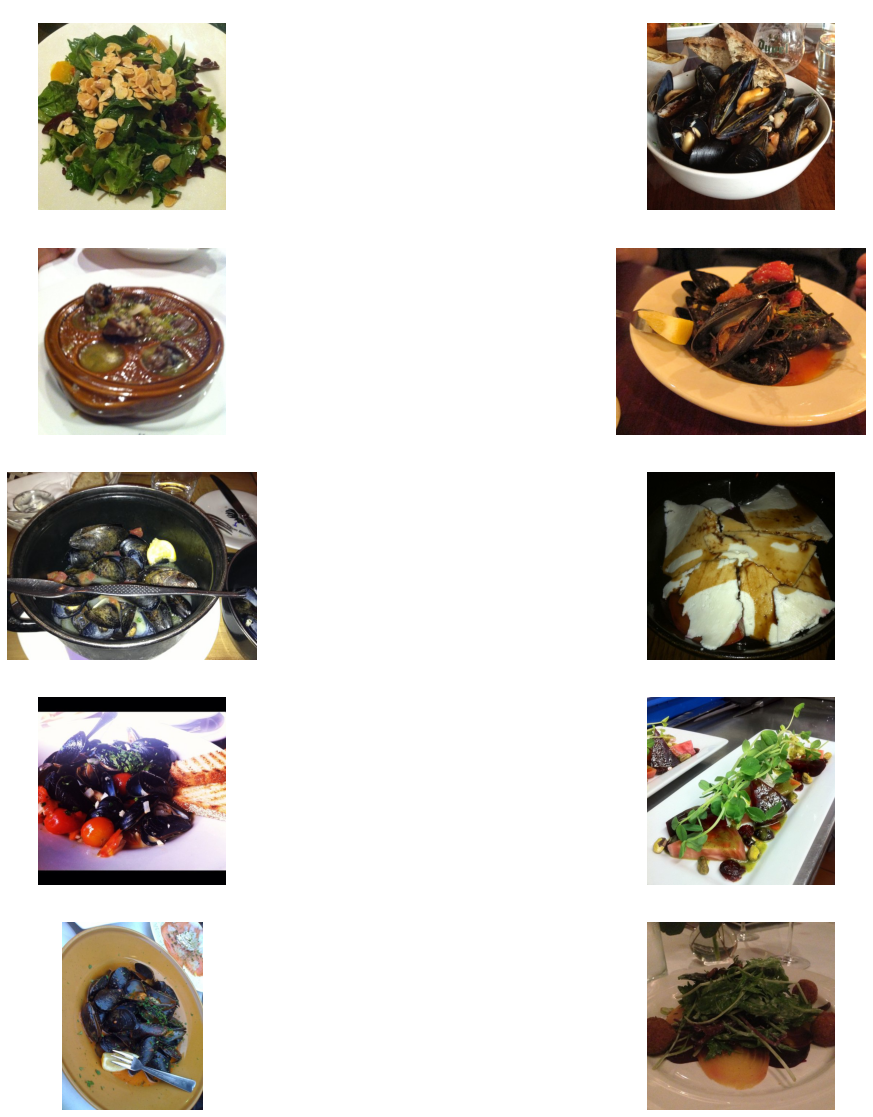

In [3]:
def view_random_image(target_dir, target_class):

  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)


  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class,color='white')
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

array = ['beet_salad', 'escargots', 'mussels']
secure_random = random.SystemRandom()
plt.figure(figsize=(20,20))
for p in range(10):
    array_choice = secure_random.choice(array)
    plt.subplot(5,2,p+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(view_random_image(target_dir="101_food_classes_10_percent/train/", target_class=array_choice))

In [4]:
tf.random.set_seed(11)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

train_data = train_datagen.flow_from_directory(test_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', seed=11)

valid_data = valid_datagen.flow_from_directory(train_dir, batch_size=32, target_size=(224, 224), class_mode='categorical', seed=11)

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


In [12]:
import datetime

IMAGE_SHAPE=(224,224)

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_1 = model_1.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data), callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="CNN")])

Saving TensorBoard log files to: 5_cnn/CNN/20211213-010637
Epoch 1/5
24/24 [==============================] - 19s 764ms/step - loss: 1.1439 - accuracy: 0.3493 - val_loss: 1.0643 - val_accuracy: 0.3689
Epoch 2/5
24/24 [==============================] - 17s 718ms/step - loss: 0.9800 - accuracy: 0.5693 - val_loss: 0.9954 - val_accuracy: 0.5067
Epoch 3/5
24/24 [==============================] - 17s 704ms/step - loss: 0.8393 - accuracy: 0.6267 - val_loss: 0.9438 - val_accuracy: 0.5778
Epoch 4/5
24/24 [==============================] - 17s 709ms/step - loss: 0.7124 - accuracy: 0.7133 - val_loss: 1.0157 - val_accuracy: 0.4889
Epoch 5/5
24/24 [==============================] - 17s 701ms/step - loss: 0.6060 - accuracy: 0.7613 - val_loss: 1.0463 - val_accuracy: 0.4889


In [13]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                 

<AxesSubplot:>

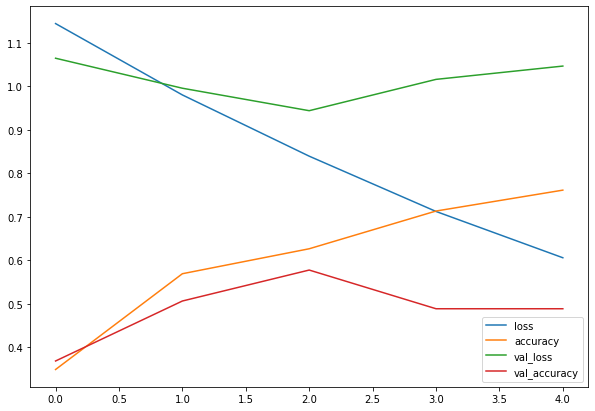

In [14]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

In [16]:
%reload_ext tensorboard
%tensorboard --logdir='5_cnn/CNN/'

Launching TensorBoard...

In [17]:
model_1_results = pd.DataFrame(history_1.history)

In [19]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5"
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

def create_BC_model(model_url):

  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, name='feature_extraction_layer', input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  model = tf.keras.Sequential([feature_extractor_layer, Dense(3, activation='sigmoid', name='output_layer')])

  return model

resnet_model = create_BC_model(resnet_url)
resnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']
)
history_2 = resnet_model.fit(train_data, epochs=5, validation_data=valid_data, callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="resnet")])

Saving TensorBoard log files to: 5_cnn/resnet/20211213-012537
Epoch 1/5
24/24 [==============================] - 65s 2s/step - loss: 0.6385 - accuracy: 0.7280 - val_loss: 0.4454 - val_accuracy: 0.8444
Epoch 2/5
24/24 [==============================] - 55s 2s/step - loss: 0.2612 - accuracy: 0.9120 - val_loss: 0.3513 - val_accuracy: 0.8711
Epoch 3/5
24/24 [==============================] - 53s 2s/step - loss: 0.1806 - accuracy: 0.9347 - val_loss: 0.3170 - val_accuracy: 0.8844
Epoch 4/5
24/24 [==============================] - 55s 2s/step - loss: 0.1359 - accuracy: 0.9653 - val_loss: 0.2938 - val_accuracy: 0.8889
Epoch 5/5
24/24 [==============================] - 56s 2s/step - loss: 0.1105 - accuracy: 0.9747 - val_loss: 0.2931 - val_accuracy: 0.8933


In [20]:
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             42605504  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 42,611,651
Trainable params: 6,147
Non-trainable params: 42,605,504
_________________________________________________________________


<AxesSubplot:>

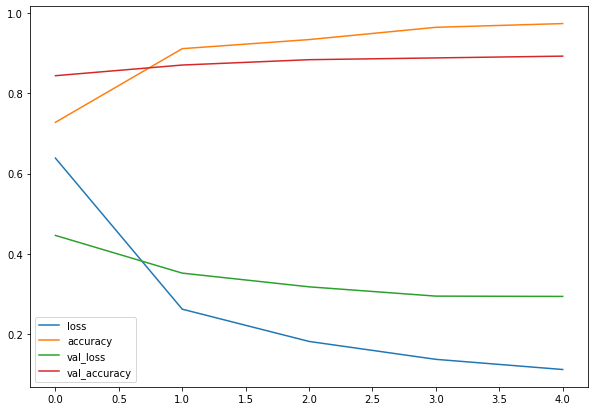

In [21]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7))

In [23]:
%reload_ext tensorboard
%tensorboard --logdir='5_cnn/resnet/'

Launching TensorBoard...

In [24]:
resnet_results = pd.DataFrame(history_2.history)

In [25]:
efficientnet_model= create_BC_model(efficientnet_url)
efficientnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_3 = efficientnet_model.fit(train_data, epochs=5, validation_data=valid_data, callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="efficientnet")])

Saving TensorBoard log files to: 5_cnn/efficientnet/20211213-013609
Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 0.6916 - accuracy: 0.7627 - val_loss: 0.4465 - val_accuracy: 0.8711
Epoch 2/5
24/24 [==============================] - 31s 1s/step - loss: 0.3094 - accuracy: 0.9387 - val_loss: 0.3132 - val_accuracy: 0.9156
Epoch 3/5
24/24 [==============================] - 31s 1s/step - loss: 0.2227 - accuracy: 0.9440 - val_loss: 0.2762 - val_accuracy: 0.9111
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.1860 - accuracy: 0.9533 - val_loss: 0.2487 - val_accuracy: 0.9289
Epoch 5/5
24/24 [==============================] - 35s 1s/step - loss: 0.1616 - accuracy: 0.9600 - val_loss: 0.2294 - val_accuracy: 0.9378


In [26]:
efficientnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


<AxesSubplot:>

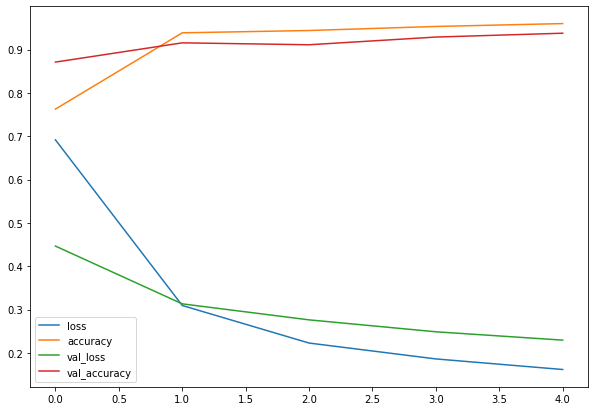

In [27]:
pd.DataFrame(history_3.history).plot(figsize=(10, 7))

In [29]:
%reload_ext tensorboard
%tensorboard --logdir='5_cnn/efficientnet/'

Launching TensorBoard...

In [30]:
efficientnet_results = pd.DataFrame(history_3.history)

In [31]:
resnet_model2= create_BC_model(resnet_url)
resnet_model2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
history_4 = resnet_model2.fit(train_data, epochs=5, validation_data=valid_data, callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="resnet_sgd")])

Saving TensorBoard log files to: 5_cnn/resnet_sgd/20211213-014124
Epoch 1/5
24/24 [==============================] - 68s 3s/step - loss: 0.5913 - accuracy: 0.7733 - val_loss: 0.4610 - val_accuracy: 0.8489
Epoch 2/5
24/24 [==============================] - 55s 2s/step - loss: 0.2475 - accuracy: 0.9147 - val_loss: 0.4492 - val_accuracy: 0.8489
Epoch 3/5
24/24 [==============================] - 55s 2s/step - loss: 0.1877 - accuracy: 0.9413 - val_loss: 0.3777 - val_accuracy: 0.8667
Epoch 4/5
24/24 [==============================] - 55s 2s/step - loss: 0.1606 - accuracy: 0.9520 - val_loss: 0.3340 - val_accuracy: 0.8667
Epoch 5/5
24/24 [==============================] - 55s 2s/step - loss: 0.1418 - accuracy: 0.9560 - val_loss: 0.3321 - val_accuracy: 0.8756


In [33]:
%reload_ext tensorboard
%tensorboard --logdir='5_cnn/resnet_sgd/'

Launching TensorBoard...

In [38]:
resnet_sgd_results = pd.DataFrame(history_4.history)

In [35]:
efficientnet_model2= create_BC_model(efficientnet_url)
efficientnet_model2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
history_5 = efficientnet_model2.fit(train_data, epochs=5, validation_data=valid_data, callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="efficientnet_sgd")])

Saving TensorBoard log files to: 5_cnn/efficientnet_sgd/20211213-014903
Epoch 1/5
24/24 [==============================] - 42s 1s/step - loss: 0.8477 - accuracy: 0.6733 - val_loss: 0.6633 - val_accuracy: 0.8267
Epoch 2/5
24/24 [==============================] - 31s 1s/step - loss: 0.5299 - accuracy: 0.8827 - val_loss: 0.4979 - val_accuracy: 0.8844
Epoch 3/5
24/24 [==============================] - 31s 1s/step - loss: 0.4078 - accuracy: 0.9133 - val_loss: 0.4211 - val_accuracy: 0.8978
Epoch 4/5
24/24 [==============================] - 31s 1s/step - loss: 0.3427 - accuracy: 0.9280 - val_loss: 0.3735 - val_accuracy: 0.9200
Epoch 5/5
24/24 [==============================] - 31s 1s/step - loss: 0.3027 - accuracy: 0.9347 - val_loss: 0.3415 - val_accuracy: 0.9156


In [37]:
%reload_ext tensorboard
%tensorboard --logdir='5_cnn/efficientnet_sgd/'

Launching TensorBoard...

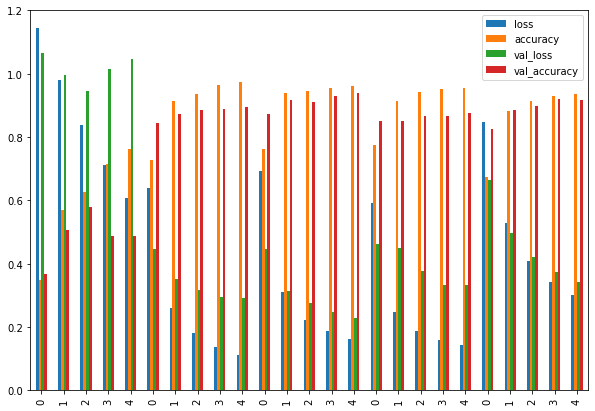

In [40]:
efficientnet_sgd_results = pd.DataFrame(history_5.history)
all_models_results = pd.concat([model_1_results, resnet_results, efficientnet_results, resnet_sgd_results, efficientnet_sgd_results])
all_models_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [43]:
for layer in resnet_model.layers[-10:]:
    layer.trainable=True

resnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_2_UPD = resnet_model.fit(train_data, epochs=2, validation_data=valid_data, callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="resnet_2")])

Saving TensorBoard log files to: 5_cnn/resnet_2/20211213-020153
Epoch 1/2
24/24 [==============================] - 327s 13s/step - loss: 1.1067 - accuracy: 0.7760 - val_loss: 1064209536.0000 - val_accuracy: 0.3333
Epoch 2/2
24/24 [==============================] - 295s 12s/step - loss: 0.9859 - accuracy: 0.7627 - val_loss: 255674.2500 - val_accuracy: 0.3333


In [44]:
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             42605504  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 42,611,651
Trainable params: 42,506,307
Non-trainable params: 105,344
_________________________________________________________________


<AxesSubplot:>

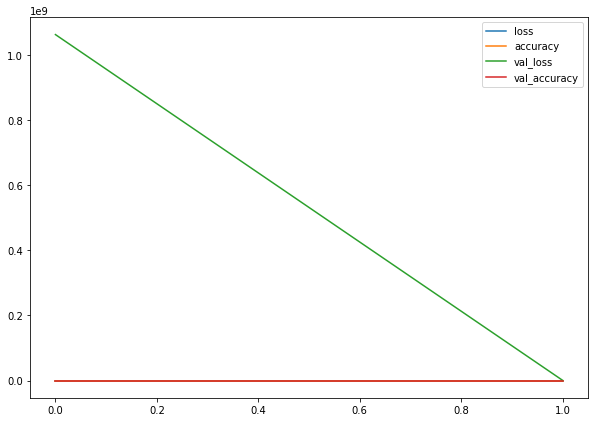

In [45]:
pd.DataFrame(history_2_UPD.history).plot(figsize=(10, 7))

In [46]:
for layer in efficientnet_model.layers[-10:]:
    layer.trainable=True

efficientnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_3_UPD = efficientnet_model.fit(train_data, epochs=2, validation_data=valid_data, callbacks=[create_tensorboard_callback(dir_name="5_cnn", experiment_name="efficientnet_2")])

Saving TensorBoard log files to: 5_cnn/efficientnet_2/20211213-021340
Epoch 1/2
24/24 [==============================] - 131s 5s/step - loss: 0.3920 - accuracy: 0.9133 - val_loss: 0.6632 - val_accuracy: 0.8578
Epoch 2/2
24/24 [==============================] - 114s 5s/step - loss: 0.2117 - accuracy: 0.9707 - val_loss: 0.6553 - val_accuracy: 0.8667


In [47]:
efficientnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 4,011,391
Non-trainable params: 42,016
_________________________________________________________________


<AxesSubplot:>

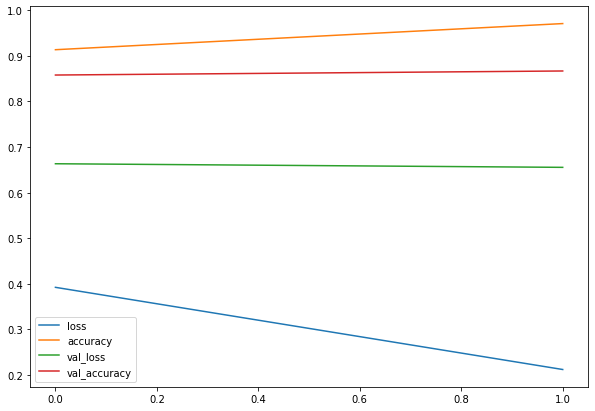

In [48]:
pd.DataFrame(history_3_UPD.history).plot(figsize=(10, 7))